# Electricity Demand Forecasting (Time-Series) with XGBoost
**Author:** Zak Mohamed

**Goal:** Forecast hourly electricity demand using time-series features and gradient boosting.  



##**Introduction**

The graph below shows **global energy consumption from 1965 to 2020, based on data from The Geography of Transport.**

Over the years, energy use has increased significantly as the world has developed and populations have grown.

In this project, we’ll analyze past energy consumption trends and use time series forecasting to predict future energy use. Understanding where energy demand is headed can help with planning for sustainable energy policies, infrastructure, and resource management.

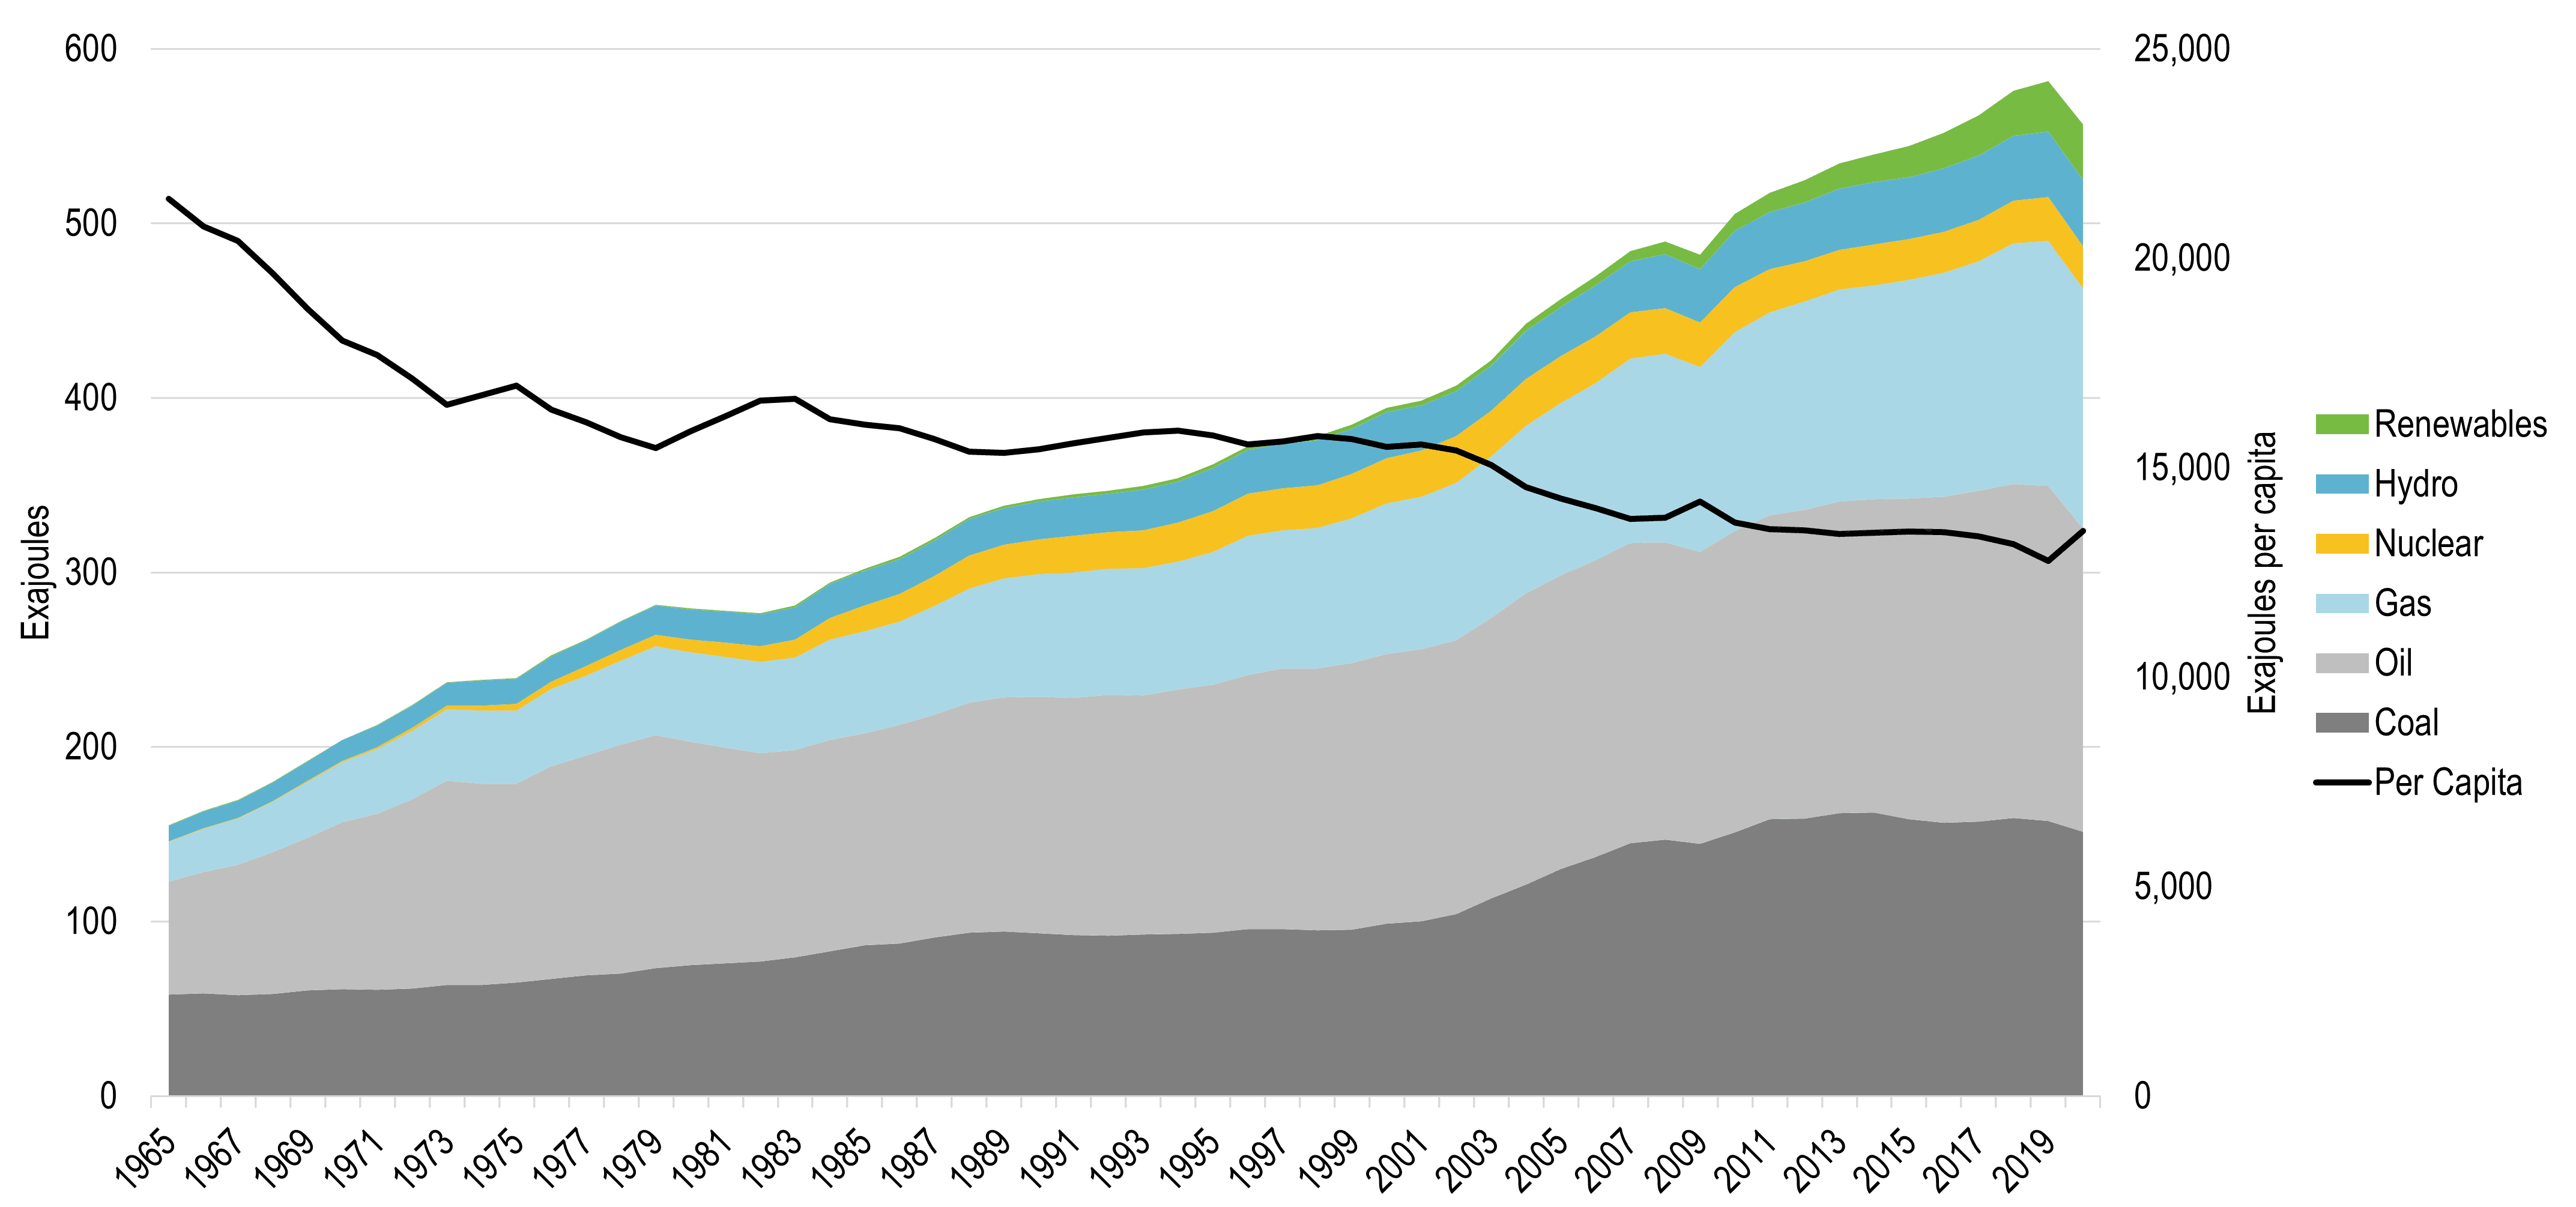

# 1. Import Libraries

In [1]:
# Core libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling & metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# Simple holiday flags using pandas' built-in US federal calendar
from pandas.tseries.holiday import USFederalHolidayCalendar as USCal

# Detect if running in Colab (for easy file upload)
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Reproducibility
RANDOM_STATE = 42

def mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error (as a percentage).
    Clips very small true values to avoid division by zero explosions.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), 1e-8, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


#2. Load Data and visualization

In [2]:
# We expect "PJME_hourly.csv" with columns: Datetime, PJME_MW
CSV_NAME = "PJME_hourly.csv"

def load_csv(csv_name: str) -> pd.DataFrame:
    """
    Try to read CSV from working directory (if you've uploaded it to drive)

    if you haven't uploaded in Colab yet,
    a prompt will come to upload it.
    """
    try:
        return pd.read_csv(csv_name)
    except FileNotFoundError:
        if IN_COLAB:
            print(f"Please upload {csv_name}")
            uploaded = files.upload()
            # take the first uploaded file
            name = list(uploaded.keys())[0]
            return pd.read_csv(io.BytesIO(uploaded[name]))
        raise  # not Colab and file not found

raw_df = load_csv(CSV_NAME)

# Quick peek to confirm columns
print("Columns:", list(raw_df.columns))
raw_df.head()


Please upload PJME_hourly.csv


Saving PJME_hourly.csv to PJME_hourly.csv
Columns: ['Datetime', 'PJME_MW']


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# Basic checks to ensure expected columns exist
assert "Datetime" in raw_df.columns, "CSV must have a 'Datetime' column."
assert "PJME_MW" in raw_df.columns,  "CSV must have a 'PJME_MW' column."

# Create a clean, indexed DataFrame sorted by time
df = raw_df.copy()
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime").sort_index()

# Sanity check: date range and size
print("Date range:", df.index.min(), "→", df.index.max())
print("Rows:", len(df))
df["PJME_MW"].describe()


Date range: 2002-01-01 01:00:00 → 2018-08-03 00:00:00
Rows: 145366


,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


#### Some visualizations of the data always helps to gain insight before processing and training

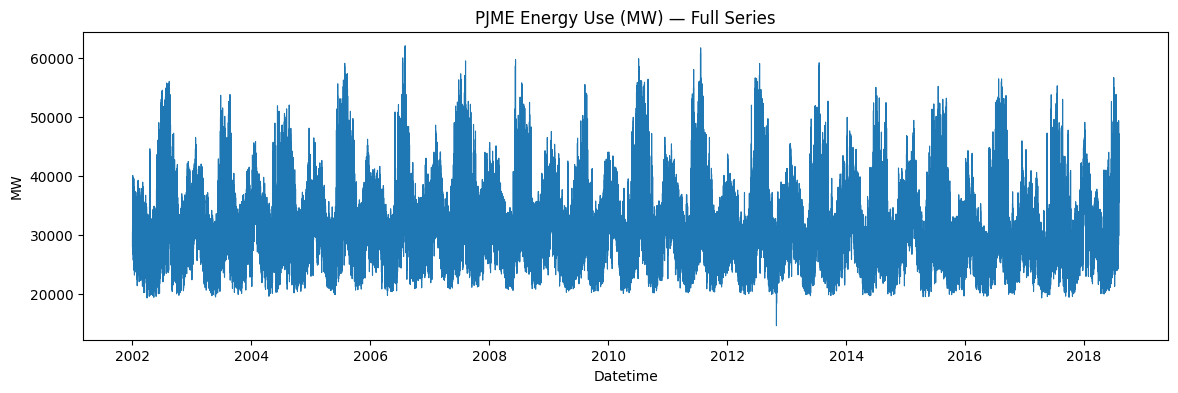

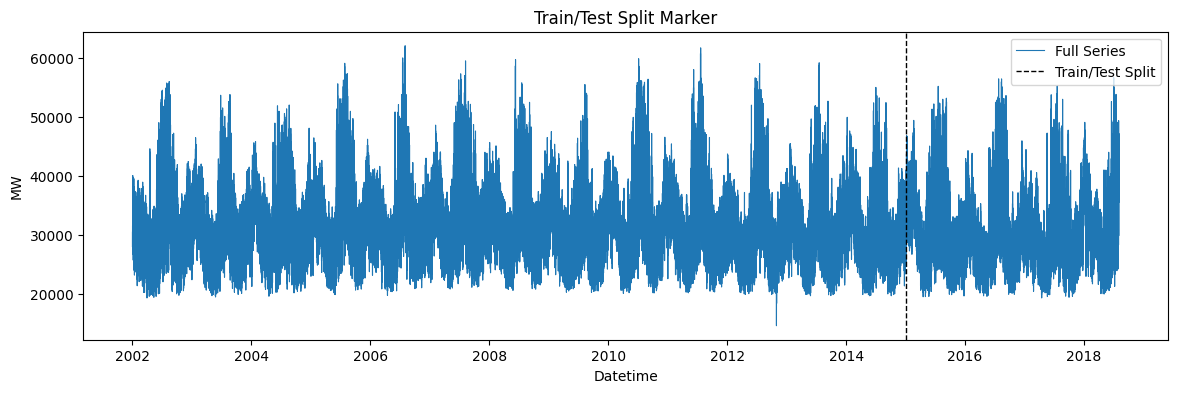

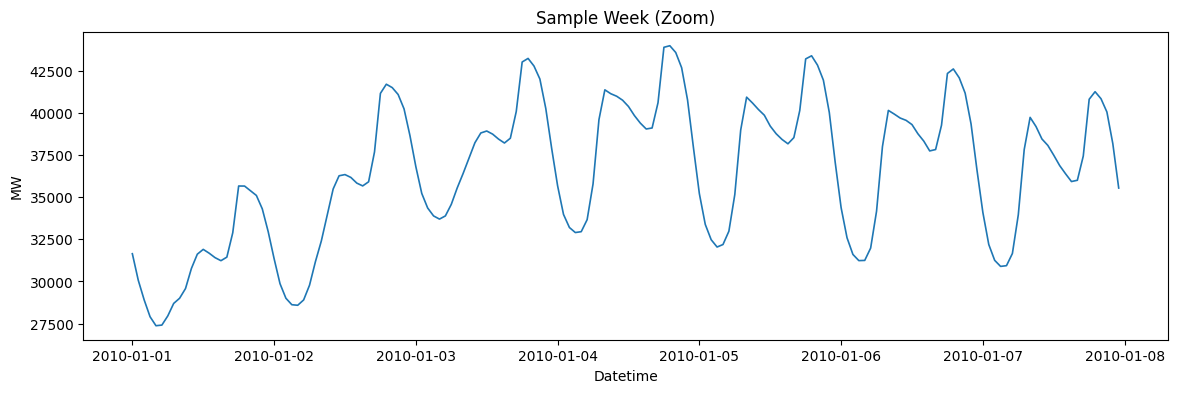

In [4]:
# Plot the full series for a quick check
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["PJME_MW"], linewidth=0.8)
plt.title("PJME Energy Use (MW) — Full Series")
plt.xlabel("Datetime"); plt.ylabel("MW")
plt.show()

# We'll use a chronological split for train/test
SPLIT_DATE = pd.Timestamp("2015-01-01")

plt.figure(figsize=(14, 4))
plt.plot(df.index, df["PJME_MW"], linewidth=0.8, label="Full Series")
plt.axvline(SPLIT_DATE, color="black", linestyle="--", linewidth=1.0, label="Train/Test Split")
plt.title("Train/Test Split Marker")
plt.xlabel("Datetime"); plt.ylabel("MW")
plt.legend()
plt.show()

# Zoom into one representative week just to see the pattern
zoom_mask = (df.index >= "2010-01-01") & (df.index < "2010-01-08")
plt.figure(figsize=(14, 4))
plt.plot(df.index[zoom_mask], df.loc[zoom_mask, "PJME_MW"], linewidth=1.2)
plt.title("Sample Week (Zoom)")
plt.xlabel("Datetime"); plt.ylabel("MW")
plt.show()


#3. Feature Engineering
**calendar, weekend/holiday, lags, rolling means**

In [5]:
def add_calendar_features(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Adds simple calendar features from the DatetimeIndex:
    hour, dayofweek, month, year, dayofyear, dayofmonth, weekofyear,
    plus weekend and US federal holiday flags.
    """
    out = frame.copy()
    idx = out.index

    # Calendar/time components
    out["hour"]       = idx.hour
    out["dayofweek"]  = idx.dayofweek
    out["month"]      = idx.month
    out["year"]       = idx.year
    out["dayofyear"]  = idx.dayofyear
    out["dayofmonth"] = idx.day

    # ISO week number (pandas returns UInt32; cast to int for modeling)
    out["weekofyear"] = idx.isocalendar().week.astype(int)

    # Weekend flag (Saturday/Sunday are 5/6)
    out["is_weekend"] = (out["dayofweek"] >= 5).astype(int)

    # US federal holidays (sufficient for PJME demo)
    cal = USCal()
    holidays = cal.holidays(start=idx.min(), end=idx.max())
    out["is_holiday"] = out.index.normalize().isin(holidays).astype(int)

    return out

def add_lags_and_rolls(frame: pd.DataFrame, target: str = "PJME_MW") -> pd.DataFrame:
    """
    Adds a few time-series features that are fast and helpful:
    - lag_24  : value 24 hours ago
    - lag_168 : value 168 hours (1 week) ago
    - rollmean_24  : rolling mean of last 24 hours (shifted by 1 to avoid leakage)
    - rollmean_168 : rolling mean of last week (shifted by 1)
    """
    out = frame.copy()
    out["lag_24"]  = out[target].shift(24)
    out["lag_168"] = out[target].shift(168)

    # Use shift(1) before rolling so we don't peek at the current hour
    out["rollmean_24"]  = out[target].shift(1).rolling(window=24,  min_periods=1).mean()
    out["rollmean_168"] = out[target].shift(1).rolling(window=168, min_periods=1).mean()

    return out

# Build feature set
feat_df = add_calendar_features(df)
feat_df = add_lags_and_rolls(feat_df, target="PJME_MW")

# Drop initial rows with NaNs introduced by lag/rolling features
feat_df = feat_df.dropna().copy()

print("After feature engineering:", feat_df.shape)
feat_df.head()


After feature engineering: (145198, 14)


,PJME_MW,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_holiday,lag_24,lag_168,rollmean_24,rollmean_168
Datetime,,,,,,,,,,,,,,
2002-01-08 01:00:00,29445.0,1,1,1,2002,8,8,2,0,0,26862.0,30393.0,33452.583333,32519.511905
2002-01-08 02:00:00,28670.0,2,1,1,2002,8,8,2,0,0,25976.0,29265.0,33560.208333,32513.869048
2002-01-08 03:00:00,28375.0,3,1,1,2002,8,8,2,0,0,25641.0,28357.0,33672.458333,32510.327381
2002-01-08 04:00:00,28542.0,4,1,1,2002,8,8,2,0,0,25666.0,27899.0,33786.375000,32510.434524
2002-01-08 05:00:00,29261.0,5,1,1,2002,8,8,2,0,0,26328.0,28057.0,33906.208333,32514.261905


##Train/Test split and feature matrix

In [6]:
# Split AFTER feature creation so both sets have all features available
train_df = feat_df.loc[feat_df.index < SPLIT_DATE].copy()
test_df  = feat_df.loc[feat_df.index >= SPLIT_DATE].copy()

# Define target and features
TARGET = "PJME_MW"
FEATURES = [
    "hour", "dayofweek", "month", "year", "dayofyear", "dayofmonth", "weekofyear",
    "is_weekend", "is_holiday",
    "lag_24", "lag_168", "rollmean_24", "rollmean_168",
]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_test  = test_df[FEATURES]
y_test  = test_df[TARGET]

print("Train rows:", len(X_train), "| Test rows:", len(X_test), "| Features:", len(FEATURES))


Train rows: 113758 | Test rows: 31440 | Features: 13


#4. Model Training
**We will use XgBoost for training and implement early stopping to prevent overfitting**

In [8]:
# A compact, sensible XGBoost config:
# - early_stopping_rounds stops training when test score stops improving
# - eval_set gives us validation feedback
# - objective='reg:squarederror' is the standard for regression
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric="rmse"
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False  # set to True if you want to see training logs,
                  #it's going to leave a massive output cell, so I chose to turn it off
)

print("Best iteration (0-based):", model.best_iteration)


Best iteration (0-based): 593


#5. Model Evaluation
**We will evaluate the model using root mean squared error (RMSE), mean absolute error (MAE), and mean absolute Percentage error (MAPE)**

In [11]:
# Predict on test set
y_pred = model.predict(X_test)

# Core metrics
# rmse = mean_squared_error(y_test, y_pred, squared=False)
      #Above code did not work with my setup. I implemented it manually below
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape_val = mape(y_test, y_pred)

print(f"Test RMSE: {rmse:,.2f} MW")
print(f"Test MAE : {mae:,.2f} MW")
print(f"Test MAPE: {mape_val:,.2f}%")


Test RMSE: 1,672.40 MW
Test MAE : 1,246.27 MW
Test MAPE: 3.90%


Our Mean absolute perecentage error is 3.90%. In Time series, anything less than 10% is considered good.

**On average, our model's predictions are off by about 1,246 MW, with a typical percentage error of just under 4%. A very good sign**

#6. Model Visualization

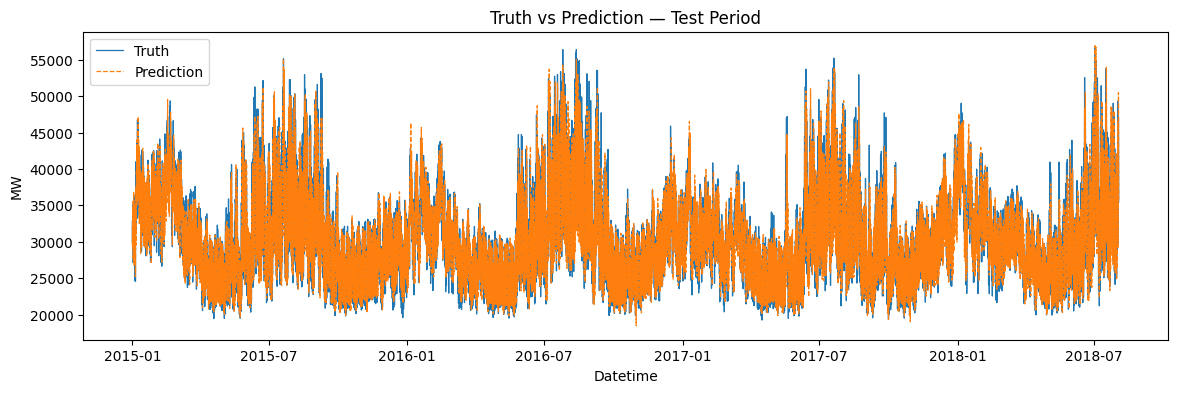

In [12]:
# Join predictions back to the indexed test frame for easy plotting
plot_df = test_df[[TARGET]].copy()
plot_df["prediction"] = y_pred

plt.figure(figsize=(14, 4))
plt.plot(plot_df.index, plot_df[TARGET], linewidth=0.9, label="Truth")
plt.plot(plot_df.index, plot_df["prediction"], linewidth=0.9, linestyle="--", label="Prediction")
plt.title("Truth vs Prediction — Test Period")
plt.xlabel("Datetime"); plt.ylabel("MW")
plt.legend()
plt.show()


Zoom into one week in testing, as we did earlier

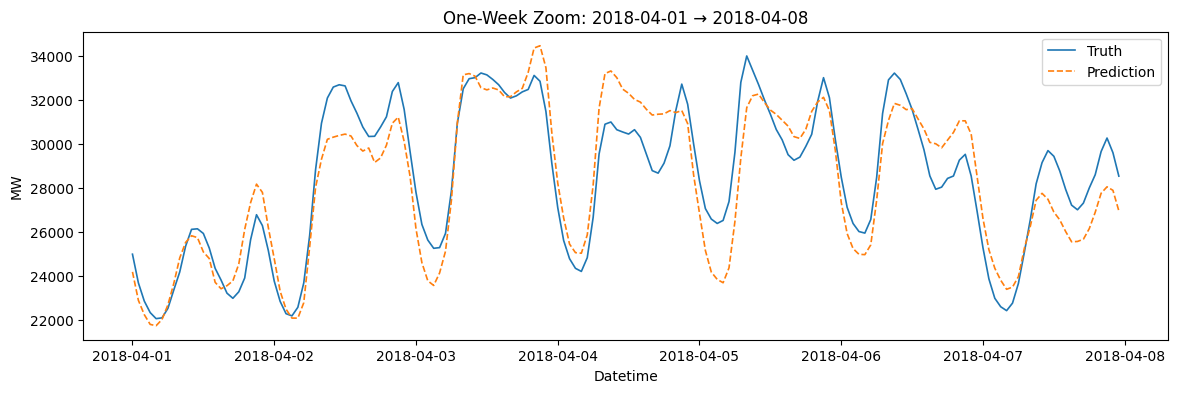

In [13]:
# Choose a known-in-range test week from the PJME dataset
zoom_start = pd.Timestamp("2018-04-01")
zoom_end   = pd.Timestamp("2018-04-08")

mask = (plot_df.index >= zoom_start) & (plot_df.index < zoom_end)

plt.figure(figsize=(14, 4))
plt.plot(plot_df.index[mask], plot_df.loc[mask, TARGET], linewidth=1.2, label="Truth")
plt.plot(plot_df.index[mask], plot_df.loc[mask, "prediction"], linewidth=1.2, linestyle="--", label="Prediction")
plt.title(f"One-Week Zoom: {zoom_start.date()} → {zoom_end.date()}")
plt.xlabel("Datetime"); plt.ylabel("MW")
plt.legend()
plt.show()


**A quick model insight wold be to check which features are important for our model**

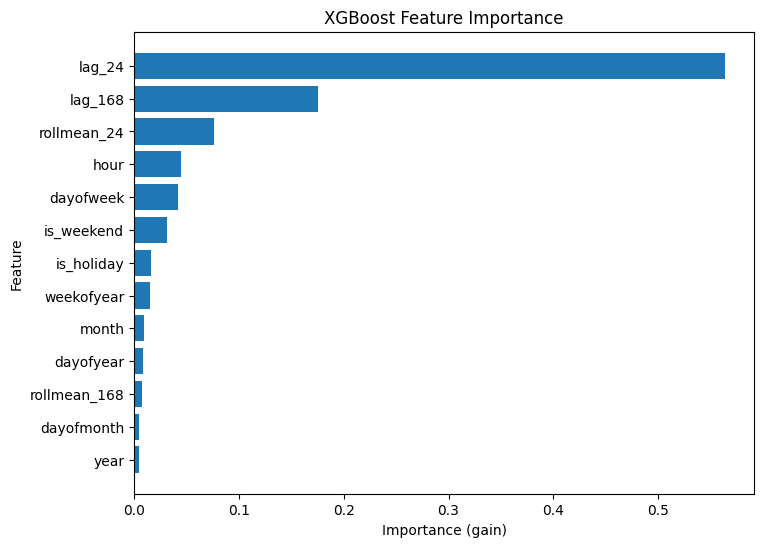

,0
lag_24,0.563279
lag_168,0.175946
rollmean_24,0.076369
hour,0.045084
dayofweek,0.042327
is_weekend,0.031101
is_holiday,0.016192
weekofyear,0.015110
month,0.009251
dayofyear,0.008775


In [14]:
# XGBoost provides gain-based importances
importances = model.feature_importances_
fi = pd.Series(importances, index=FEATURES).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(fi.index, fi.values)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance (gain)")
plt.ylabel("Feature")
plt.show()

# Print top features
fi.sort_values(ascending=False).head(10)


- As we can see, the features that are incredibly useful for our predictions of consumption is how the electricity was being used 24 hours ago, followed by how much electricity was consumed one week ago followed by the mean of the last 24 hours

- Those 3 features especially, were the best indicators to know how electricity will be consumed in any given day.

- SHows you why feature engineering is important

- **Now let's see what days were hardest**

Error Analysis

In [15]:
# Absolute error per timestamp
plot_df["abs_error"] = np.abs(plot_df[TARGET] - plot_df["prediction"])
# Group by date to see which days are toughest/best on average
per_day = plot_df.groupby(plot_df.index.date)["abs_error"].mean().sort_values(ascending=False)

print("Top 10 worst days (highest mean absolute error):")
print(per_day.head(10))

print("\nTop 10 best days (lowest mean absolute error):")
print(per_day.tail(10))


Top 10 worst days (highest mean absolute error):
2017-12-31    4427.996419
2018-05-29    4287.741374
2018-06-03    4188.429118
2016-08-11    4112.337972
2017-05-20    4038.549886
2015-02-15    3881.513346
2015-02-19    3863.022135
2016-12-15    3803.781169
2016-07-05    3749.298747
2015-09-09    3613.281006
Name: abs_error, dtype: float64

Top 10 best days (lowest mean absolute error):
2016-05-22    257.331543
2016-10-13    253.698161
2015-09-22    253.664551
2015-04-22    252.344564
2016-05-04    243.741618
2018-04-25    241.379476
2017-05-11    240.303874
2017-04-25    238.317546
2015-05-22    229.203206
2016-05-11    198.317871
Name: abs_error, dtype: float64


**Summary of the Project**

In [18]:
import pandas as pd

metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "MAPE"],
    "Value": [f"{rmse:,.2f} MW", f"{mae:,.2f} MW", f"{mape_val:,.2f}%"]
})

display(metrics_df)


,Metric,Value
0,RMSE,"1,672.40 MW"
1,MAE,"1,246.27 MW"
2,MAPE,3.90%
